<a href="https://colab.research.google.com/github/ayanga1998/COVID-19-CT-Scan-Classification/blob/main/Code/CNN_COVID_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Network for COVID-19 Diagnosis using CT Scan Images


## Preprocessing the Data
**Overview**


*   Import all dependencies
*   Extract file links from database and split into training, validation, and test partitions (60/20/20 split)
*   Establish Dataset Class to process and load images in mini-batches




In [4]:
!pip install torchinfo

In [5]:
import os  
import glob
import sklearn
from sklearn.model_selection import train_test_split

import PIL 
import numpy as np
import matplotlib.pyplot as plt 

import torch
import torch.nn as nn
from torchinfo import summary 

import torch.optim as optim
from IPython.display import Image
from torch.utils.data import DataLoader, Dataset

from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device 

device(type='cuda')

In [25]:
random_seed = 124
np.random.seed(random_seed)

torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

Extract file links for both labels and perform split the data into train, validation, and test partitions

In [26]:
path = '/content/drive/MyDrive/Data/COVID/'

pos_files = glob.glob(os.path.join(path, "CT_COVID",'*.*'))
neg_files = glob.glob(os.path.join(path, 'CT_NonCOVID','*.*'))

images = pos_files + neg_files
labels = np.array([1]*len(pos_files)+[0]*len(neg_files))

images_tv, images_test, y_tv, y_test  = train_test_split(images, labels, shuffle=True, test_size=0.2, random_state=123)
images_train, images_val, y_train, y_val  = train_test_split(images_tv, y_tv, shuffle=True, test_size=0.25, random_state=123)

Plot a few sample images

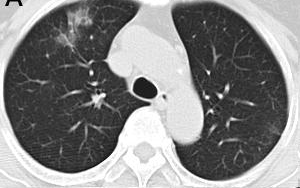

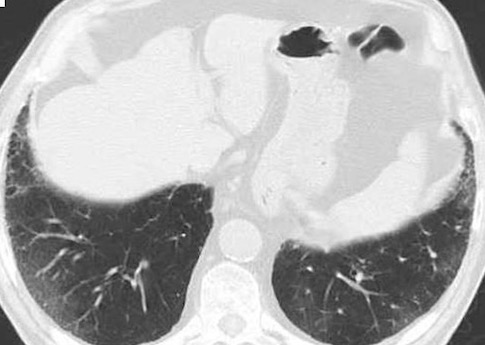

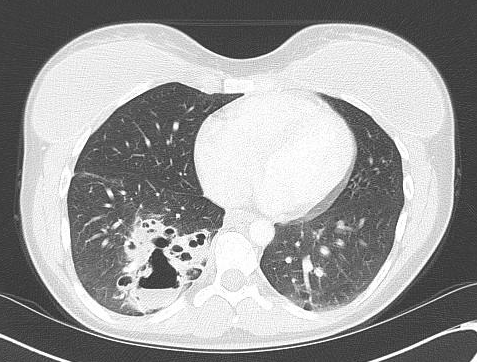

In [27]:
Image(images_train[1])
Image(images_train[15])
Image(images_train[66])

Based on the output below, we are working with a balanced but relatively small dataset of images

In [28]:
print(f'Number of samples in each set (train, val, test): {len(y_train), len(y_val), len(y_test)}')

print(f'Number of positive samples in each set: {y_train.sum(), y_val.sum(), y_test.sum()}')

Number of samples in each set (train, val, test): (447, 149, 150)
Number of positive samples in each set: (207, 71, 71)


### Datasset Class
**Image Transformations**: Convert images to grayscale, resize images to 250 x 250 and transform to tensor\
**Get Item**: Only load images for each minibatch when called to save computational resources

In [96]:
class CT_Dataset(Dataset):
    def __init__(self, img_path, img_labels, img_transforms=None, grayscale=False):
        self.img_path = img_path
        self.img_labels = torch.Tensor(img_labels)
        if (img_transforms is None) & (grayscale == False):
            self.transforms = transforms.Compose([transforms.Grayscale(),
                                                  transforms.Resize((250, 250)),
                                                  transforms.ToTensor()])
        elif grayscale == True:
            self.transforms = transforms.Compose([transforms.Resize((250, 250)),
                                                  transforms.ToTensor()])
        else:
            self.transforms = img_transforms
    
    def __getitem__(self, index):
        # load image
        cur_path = self.img_path[index]
        cur_img = PIL.Image.open(cur_path).convert('RGB')
        cur_img = self.transforms(cur_img)

        return cur_img, self.img_labels[index]
    
    def __len__(self):
        return len(self.img_path)

## Creating our Model

- Create a CNN models with appropriate layers of `Convolution`, `MaxPooling2D`, and `Dense` layers. Use appropriate activation functions for these layers.
- Since this dataset is small, it may be easily get overfitted. Leverage `Dropout` or other regularization techniques to fight overfitting
- Configure your model with appropriate optimizer and loss function.

#### Network Configuration

The model used for this exercise has several key layers:


*   Conv2D $\rightarrow$ Batch Normalization $\rightarrow$ ReLU Activation $\rightarrow$ AvgPooling2D
  * Output Channels: 64
  * Filter Size: 3x3
  * AvgPooling Filter Size: 2x2
*   Conv2D $\rightarrow$ Batch Normalization $\rightarrow$ ReLU Activation $\rightarrow$ AvgPooling2D
  * Output Channels: 128
  * Filter Size: 3x3
  * AvgPooling Filter Size: 2x2
*   Conv2D $\rightarrow$ Batch Normalization $\rightarrow$ ReLU Activation $\rightarrow$ AvgPooling2D
  * Output Channels: 256
  * Filter Size: 3x3
  * AvgPooling Filter Size: 2x2
*   Conv2D $\rightarrow$ Batch Normalization $\rightarrow$ ReLU Activation $\rightarrow$ AvgPooling2D
  * Output Channels: 128
  * Filter Size: 3x3
  * AvgPooling Filter Size: 2x2
*   Conv2D $\rightarrow$ Batch Normalization $\rightarrow$ ReLU Activation $\rightarrow$ AvgPooling2D $\rightarrow$ Flatten
  * Output Channels: 64
  * Filter Size: 3x3
  * AvgPooling Filter Size: 2x2
  * Output Shape (After Flatten): (Batch Size, 1600)

After the series of convolutions, we pass the parameters through a series of Dropout, Linear, and ReLU layers and produce an output of shape (Batch Size, 1)
*   Dropout $\rightarrow$ Linear $\rightarrow$ ReLU Activation $\rightarrow$ Dropout $\rightarrow$ Linear $\rightarrow$ ReLU Activation $\rightarrow$ Linear
  * Dropout Ratio: 0.5



In [53]:
# define CNN mode
class Convnet(nn.Module):
    
    def __init__(self, dropout=0.5):
        super(Convnet, self).__init__()
        self.convnet = nn.Sequential(
          # input (num_batch, 1, 250, 250)
          nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3),  # (num_batch, 64, 248, 248)
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),  # (num_batch, 64, 124, 124)

          nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3), # (num_batch, 128, 122, 122)
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),  # (num_batch, 128, 61, 61)

          nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3), # (num_batch, 256, 59, 59)
          nn.BatchNorm2d(256),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),  # (num_batch, 256, 29, 29)

          nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3), # (num_batch, 128, 27, 27)
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),  # (num_batch, 128, 13, 13)

          nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3), # (num_batch, 64, 11, 11)
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),  # (num_batch, 64, 5, 5)
          nn.Flatten() # (num_batch, 1600)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),  # Dropout before first linear layer since it has a large number of trainable parameters
            nn.Linear(in_features= 1600, out_features=128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=1)
        )
    def forward(self, x):
        x = self.convnet(x)
        x = self.classifier(x)
        return x

#### Print model summary to  visualize network structure

In [54]:
vision_model = Convnet()
summary(vision_model, (32, 1, 250, 250))

Layer (type:depth-idx)                   Output Shape              Param #
Convnet                                  --                        --
├─Sequential: 1-1                        [32, 1600]                --
│    └─Conv2d: 2-1                       [32, 64, 248, 248]        640
│    └─BatchNorm2d: 2-2                  [32, 64, 248, 248]        128
│    └─ReLU: 2-3                         [32, 64, 248, 248]        --
│    └─MaxPool2d: 2-4                    [32, 64, 124, 124]        --
│    └─Conv2d: 2-5                       [32, 128, 122, 122]       73,856
│    └─BatchNorm2d: 2-6                  [32, 128, 122, 122]       256
│    └─ReLU: 2-7                         [32, 128, 122, 122]       --
│    └─MaxPool2d: 2-8                    [32, 128, 61, 61]         --
│    └─Conv2d: 2-9                       [32, 256, 59, 59]         295,168
│    └─BatchNorm2d: 2-10                 [32, 256, 59, 59]         512
│    └─ReLU: 2-11                        [32, 256, 59, 59]         --
│ 

### Model Training Procedure
The training sequence used for our CNN model is summarized below:


*   **Loss Function**: *Binary Cross Entropy w/ Logistic Loss*
*   **Optimizer**: *Stochastic Gradient Descent w/ Momentum*
  * To fight overfitting the following methods were used:
      * **L2 Regularization**: Weight regularization using L2 Norm
      * **Nesterov Momentum**
      * **Learning Schedule**: *Decrease the learning rate* over a set period of epochs

Parameters used for training:


*   **Initial Learning Rate**: 0.01
*   Learning Schedule: 
  * **Gamma**: 0.5
  * **Patience**: 7 epochs
*   **Number of Epochs**: 75
*   **Batch Size**: 32
*   **L2 Weight Decay**: 0.00001
*   **Nesterov Momentum Coeff**: 0.8






In [55]:
# define training function

def train_model(model, train_dataset, val_dataset, test_dataset, device, 
                lr=0.0001, epochs=30, batch_size=32, l2=0.00001, gamma=0.5,
                mom=0.6, patience=7):
  model = model.to(device)

  # construct dataloader
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

  # history
  history = {'train_loss': [],
             'train_acc': [],
             'val_loss': [],
             'val_acc': []}

  # set up loss function and optimizer
  criterion = nn.BCEWithLogitsLoss()  
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2)  # pass in the parameters to be updated and learning rate
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=patience, gamma=gamma)

  # Training Loop
  print("Training Start:")
  for epoch in range(epochs):
    model.train()  # start to train the model, activate training behavior

    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0

    for i, (images, labels) in enumerate(train_loader):
      # reshape images
      images = images.to(device)  # reshape: from (128, 1, 28, 28) -> (128, 28 * 28) = (128, 284), move batch to device
      labels = labels.to(device)  # move to device
      # forward
      outputs = model(images).view(-1)  # forward
      pred = torch.sigmoid(outputs)
      pred = torch.round(pred)
    
      cur_train_loss = criterion(outputs, labels)  # loss
      cur_train_acc = (pred == labels).sum().item() / batch_size

      # backward
      cur_train_loss.backward()   # run back propagation
      optimizer.step()            # optimizer update all model parameters
      optimizer.zero_grad()       # set gradient to zero, avoid gradient accumulating

      # loss
      train_loss += cur_train_loss 
      train_acc += cur_train_acc
        
    # valid
    model.eval()  # start to train the model, activate training behavior
    with torch.no_grad():  # tell pytorch not to update parameters
      for images, labels in val_loader:
        # calculate validation loss
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images).view(-1)

        # loss
        cur_valid_loss = criterion(outputs, labels)
        val_loss += cur_valid_loss
        # acc
        pred = torch.sigmoid(outputs)
        pred = torch.round(pred)
        val_acc += (pred == labels).sum().item() / batch_size

    # learning schedule step
    scheduler.step()

    # print training feedback
    train_loss = train_loss / len(train_loader)
    train_acc = train_acc / len(train_loader)
    val_loss = val_loss / len(val_loader)
    val_acc = val_acc / len(val_loader)

    print(f"Epoch:{epoch + 1} / {epochs}, lr: {optimizer.param_groups[0]['lr']:.5f} train loss:{train_loss:.5f}, train acc: {train_acc:.5f}, valid loss:{val_loss:.5f}, valid acc:{val_acc:.5f}")
    
    # update history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
  test_acc = 0

  with torch.no_grad():
    for images, labels in test_loader:
      images, labels = images.to(device), labels.to(device)

      # calculate outputs by running images through the network
      outputs = model(images)

      # the class with the highest energy is what we choose as prediction
      pred = torch.sigmoid(outputs)
      pred = torch.round(pred)
      test_acc += (pred == labels).sum().item()

  print(f'Test Accuracy:  {(test_acc / len(test_loader))}')

  return history

Train the model

In [58]:
# Load the data
train_dataset = CT_Dataset(img_path=images_train, img_labels=y_train)
val_dataset = CT_Dataset(img_path=images_val, img_labels=y_val)
test_dataset = CT_Dataset(img_path=images_test, img_labels=y_test)

# Train the CNN model
cnn_model = Convnet(dropout=0.5)
hist = train_model(cnn_model, train_dataset, val_dataset, test_dataset, device, lr=0.0001, batch_size=16, epochs=75, mom=0.8, l2=0.001, patience=15)

Training Start:
Epoch:1 / 75, lr: 0.00010 train loss:0.69361, train acc: 0.52232, valid loss:0.69345, valid acc:0.48750
Epoch:2 / 75, lr: 0.00010 train loss:0.66263, train acc: 0.60045, valid loss:0.67471, valid acc:0.48750
Epoch:3 / 75, lr: 0.00010 train loss:0.63449, train acc: 0.66964, valid loss:0.63083, valid acc:0.64375
Epoch:4 / 75, lr: 0.00010 train loss:0.59945, train acc: 0.68750, valid loss:0.57512, valid acc:0.63750
Epoch:5 / 75, lr: 0.00010 train loss:0.56567, train acc: 0.70312, valid loss:0.65976, valid acc:0.56875
Epoch:6 / 75, lr: 0.00010 train loss:0.53352, train acc: 0.75893, valid loss:1.02022, valid acc:0.50625
Epoch:7 / 75, lr: 0.00010 train loss:0.53778, train acc: 0.73438, valid loss:0.51263, valid acc:0.66250
Epoch:8 / 75, lr: 0.00010 train loss:0.49015, train acc: 0.76786, valid loss:0.67318, valid acc:0.62500
Epoch:9 / 75, lr: 0.00010 train loss:0.44553, train acc: 0.78795, valid loss:0.53203, valid acc:0.70000
Epoch:10 / 75, lr: 0.00010 train loss:0.37769, t

Text(0.5, 1.0, 'Loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'Accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Acc')

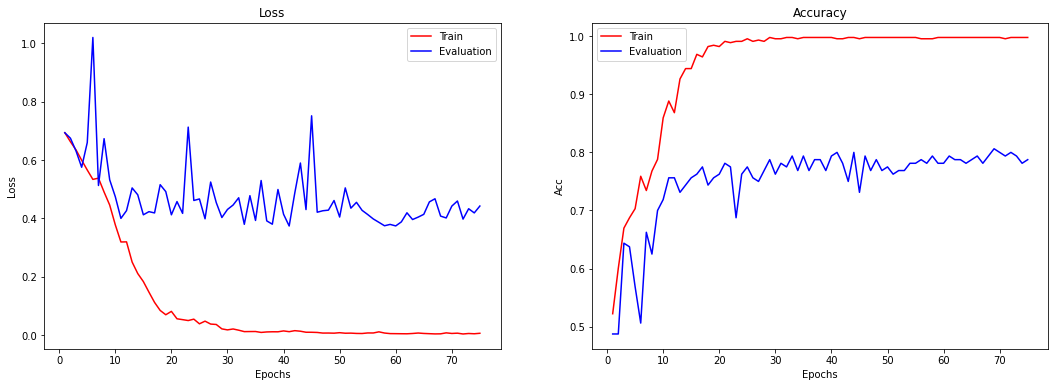

In [59]:
# plot training curves
epochs = range(1, len(hist['train_loss']) + 1)

fig, ax = plt.subplots(1,2, figsize=(18,6))
ax[0].plot(epochs, hist['train_loss'], 'r-', label='Train')
ax[0].plot(epochs, hist['val_loss'], 'b-', label='Evaluation')
ax[0].set_title('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()


ax[1].plot(epochs, hist['train_acc'], 'r-', label='Train')
ax[1].plot(epochs, hist['val_acc'], 'b-', label='Evaluation')
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Acc')
ax[1].legend()

plt.show()

#### Results Without Augmentation

The learning curves shown above show reasonable results.

**Observations** (NOTE: Numbers will vary with each model run)


*   The model begins to overfit on the training data after 20 epochs
*   Training Accuracy generally reaches around 95\%
* Validation accuracy stabilizes at around 78\%.
* Training loss converges around 0.2
* Validation loss converges around 0.4
* Test Accuracy ranges between 76-81.5\%

Overall, the model fits the training set well, reaching high accuracy and low loss in training but is quite average both on the training and validation sets

**Considerations to fight overfitting**


*   Add L1 Regularization
*   Data Augmentation (see next section)
*   Transfer Learning
  * Utilize pre-trained models built to address medical images since we have such a small amount of data
*   More hyperparameter tuning



## Data Augmentation

Since we have a small dataset, a thought is that perhaps we can improve the performance by data augmentation


- Modify your Dataset class to add appropriate data augumentation. Check the augmentation techniques here: https://pytorch.org/vision/stable/transforms.html
- Try 2 augmentation techniques to see if this can improve model performance on testing
- Note that CT scans usually are well positioned. Just try minor adjustment without unrealistic changes to images. 

- Repeat Task 1.3 with the augmented data 

- For this CT image dataset, it is not guranteed that augmentation may help. Just give a try and anazye why your augmentation techniques may (or may not) help.

#### Augmentations Used
* **Grayscale**
* **Resize** $\rightarrow$ 250 x 250
* **RandomAffine**
  * **Translate**: Width $\rightarrow$ 0.01, Height $\rightarrow$ 0.001
  * **Image Scaling**: Width $\rightarrow$ 1.2x, Height $\rightarrow$ 1.2x
  * **Shear**: 0.9
* **RandomRotation**: 20 degrees
* **Convert Image to Tensor**

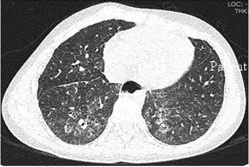

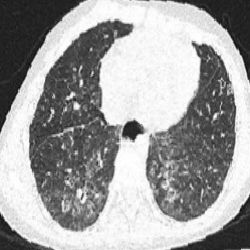

In [78]:
img = PIL.Image.open(images_train[10])

img_trans = transforms.Compose([transforms.Grayscale(),
                                transforms.RandomRotation(5),
                                transforms.Resize((250, 250)),
                                transforms.RandomAffine(degrees=0, scale=(1.1, 1.1), shear=0.9),
                                transforms.ToTensor()
                                ])
trans = img_trans(img)
display(img)
display(transforms.ToPILImage()(trans))

#### Data Augmentation Approach 1: Fully Augment the Training Set


In [79]:
train_dataset_full_aug = CT_Dataset(img_path=images_train, img_labels=y_train, img_transforms=img_trans)
val_dataset = CT_Dataset(img_path=images_val, img_labels=y_val)
test_dataset = CT_Dataset(img_path=images_test, img_labels=y_test)

In [81]:
# Train the CNN model
cnn_model = Convnet()
hist_full_aug = train_model(cnn_model, train_dataset_full_aug, val_dataset, 
                            test_dataset, device, lr=0.001, batch_size=32, epochs=75,
                            mom=0.8, gamma=0.75, l2=0.0001, patience=15)

Training Start:
Epoch:1 / 75, lr: 0.00100 train loss:0.69288, train acc: 0.54911, valid loss:0.64405, valid acc:0.61250
Epoch:2 / 75, lr: 0.00100 train loss:0.63577, train acc: 0.64286, valid loss:0.81113, valid acc:0.48750
Epoch:3 / 75, lr: 0.00100 train loss:0.62463, train acc: 0.66295, valid loss:0.58057, valid acc:0.65625
Epoch:4 / 75, lr: 0.00100 train loss:0.61193, train acc: 0.66741, valid loss:0.56284, valid acc:0.64375
Epoch:5 / 75, lr: 0.00100 train loss:0.59481, train acc: 0.70089, valid loss:0.53162, valid acc:0.68750
Epoch:6 / 75, lr: 0.00100 train loss:0.54998, train acc: 0.70759, valid loss:0.57998, valid acc:0.63750
Epoch:7 / 75, lr: 0.00100 train loss:0.52725, train acc: 0.72545, valid loss:0.54594, valid acc:0.70000
Epoch:8 / 75, lr: 0.00100 train loss:0.50706, train acc: 0.72991, valid loss:0.52591, valid acc:0.66875
Epoch:9 / 75, lr: 0.00100 train loss:0.49189, train acc: 0.74107, valid loss:0.52136, valid acc:0.72500
Epoch:10 / 75, lr: 0.00100 train loss:0.46388, t

KeyboardInterrupt: ignored

Text(0.5, 1.0, 'Loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'Accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Acc')

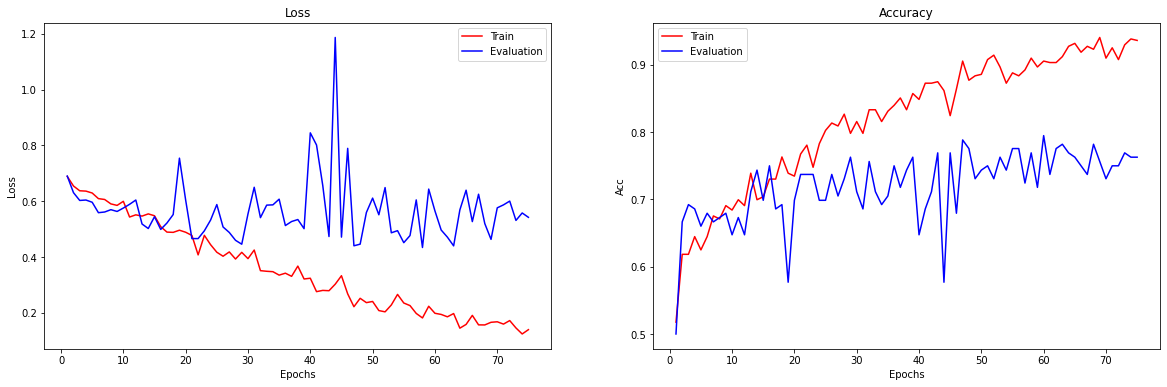

In [70]:
# plot training curves
epochs = range(1, len(hist['train_loss']) + 1)

fig, ax = plt.subplots(1,2, figsize=(20,6))
ax[0].plot(epochs, hist_full_aug['train_loss'], 'r-', label='Train')
ax[0].plot(epochs, hist_full_aug['val_loss'], 'b-', label='Evaluation')
ax[0].set_title('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epochs, hist_full_aug['train_acc'], 'r-', label='Train')
ax[1].plot(epochs, hist_full_aug['val_acc'], 'b-', label='Evaluation')
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Acc')
ax[1].legend()

plt.show()

#### Results from Approach 1

**Observations**

*   Drop in overall accuracy for both training and validation sets
*   Validation loss has increased by 0.1 in comparison to the results with no augmentation
* The model generalizes worse on the validation set than previously and training performance has also suffered
* The test accuracy dropped by roughly 10 \%
* The drop in overall performance may suggest that perhaps lack of data could be a contributing factor




#### Approach 2: Concatenate Augmented Data to Original Dataset
In this approach, the aim is to see if adding augmented samples into our dataset can help fight overfitting. We know that our sample size is small, so perhaps adding variations of samples on top of our original data may allow our model to generalize better. In doing this, we also run the risk of increasing the bias of our model.


In the code below we will augment 60 images from the training set and 20 images from the validation set and concatenate them on the original data. 


In [82]:
train_dataset_og = CT_Dataset(img_path=images_train, img_labels=y_train)
train_dataset_aug = CT_Dataset(img_path=images_train[:60], img_labels=y_train[:60], img_transforms=img_trans)
train_dataset_fin = torch.utils.data.ConcatDataset([train_dataset_og,train_dataset_aug])

val_dataset_og = CT_Dataset(img_path=images_val, img_labels=y_val)
val_dataset_aug = CT_Dataset(img_path=images_val[:20], img_labels=y_val[:25], img_transforms=img_trans)
val_dataset_fin = torch.utils.data.ConcatDataset([val_dataset_og, val_dataset_aug])

test_dataset = CT_Dataset(img_path=images_test, img_labels=y_test)

In [83]:
print(len(train_dataset_fin))
print(len(val_dataset_fin))

507
169


In [84]:
# Train the CNN model
cnn_model = Convnet(dropout=0.5)
hist_concat = train_model(cnn_model, train_dataset_fin, val_dataset_fin, test_dataset, device, lr=0.01, batch_size=32, epochs=75, mom=0.8)

Training Start:
Epoch:1 / 75, lr: 0.01000 train loss:1.10283, train acc: 0.49609, valid loss:1.15989, valid acc:0.46875
Epoch:2 / 75, lr: 0.01000 train loss:0.66468, train acc: 0.54883, valid loss:0.72480, valid acc:0.46875
Epoch:3 / 75, lr: 0.01000 train loss:0.66598, train acc: 0.52539, valid loss:0.68162, valid acc:0.46875
Epoch:4 / 75, lr: 0.01000 train loss:0.67011, train acc: 0.54688, valid loss:0.68631, valid acc:0.46875
Epoch:5 / 75, lr: 0.01000 train loss:0.63484, train acc: 0.60352, valid loss:0.78288, valid acc:0.59896
Epoch:6 / 75, lr: 0.01000 train loss:0.64544, train acc: 0.59961, valid loss:0.64306, valid acc:0.58333
Epoch:7 / 75, lr: 0.00500 train loss:0.63264, train acc: 0.66016, valid loss:0.56879, valid acc:0.60417
Epoch:8 / 75, lr: 0.00500 train loss:0.61425, train acc: 0.64062, valid loss:0.79134, valid acc:0.46875
Epoch:9 / 75, lr: 0.00500 train loss:0.60454, train acc: 0.65625, valid loss:0.60923, valid acc:0.61458
Epoch:10 / 75, lr: 0.00500 train loss:0.58498, t

Text(0.5, 1.0, 'Loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'Accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Acc')

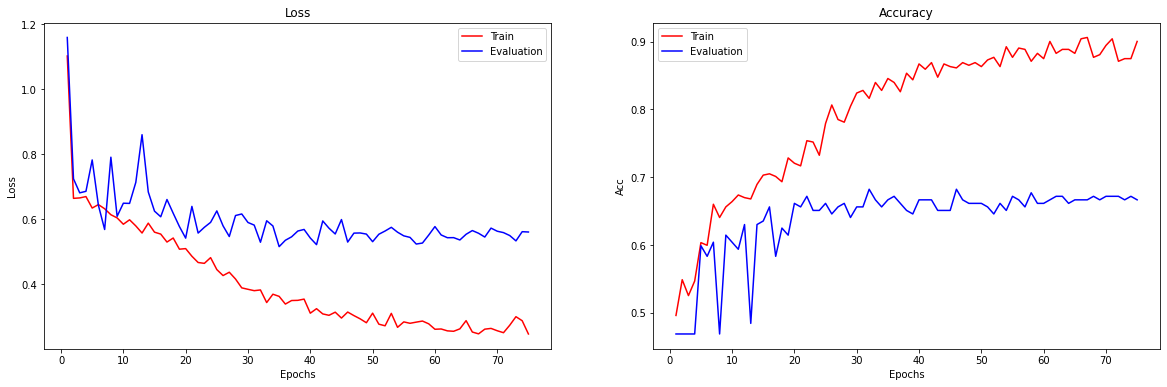

In [85]:
# plot training curves
epochs = range(1, len(hist['train_loss']) + 1)

fig, ax = plt.subplots(1,2, figsize=(20,6))
ax[0].plot(epochs, hist_concat['train_loss'], 'r-', label='Train')
ax[0].plot(epochs, hist_concat['val_loss'], 'b-', label='Evaluation')
ax[0].set_title('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()


ax[1].plot(epochs, hist_concat['train_acc'], 'r-', label='Train')
ax[1].plot(epochs, hist_concat['val_acc'], 'b-', label='Evaluation')
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Acc')
ax[1].legend()

plt.show()

#### Results from Approach 2 
**Observations**


*   Test Accuracy: ~77\%
*   Training and Validation loss are closer in comparison to the other methods
*   Much like the first approach, there is a noticeable decrease in accuracy and increase in loss for both training and valiadation sets
*   The model generalizes better than when augmenting the entire set. 
*   It would be interesting to see how the model reacts to adding a greater portion of augmented samples on top of the original dataset


## Transfer Learning (VGG-16)

In [99]:
import torchvision.models as models

VGG_model = models.vgg16(pretrained=True)

In [100]:
print(VGG_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [115]:
VGG_model = models.vgg16(pretrained=True)

for name, param in VGG_model.named_parameters():
  param.requires_grad = False

# define out classifier
binary_classifier = nn.Sequential(
   nn.Linear(in_features=25088, out_features=2048),
   nn.ReLU(),
   nn.Linear(in_features=2048, out_features=1024),
   nn.ReLU(),
   nn.Linear(in_features=1024, out_features=512),
   nn.ReLU(),
   nn.Linear(in_features=512, out_features=1)
)

# replace model class classifier attribute:
VGG_model.classifier = binary_classifier

In [116]:
train_dataset = CT_Dataset(img_path=images_train, img_labels=y_train, grayscale=True)
val_dataset = CT_Dataset(img_path=images_val, img_labels=y_val, grayscale=True)
test_dataset = CT_Dataset(img_path=images_test, img_labels=y_test, grayscale=True)

# Train the CNN model
hist = train_model(VGG_model, train_dataset, val_dataset, test_dataset, device, lr=0.0001, batch_size=32, epochs=20, mom=0.8, l2=0.2
                   , patience=15)

Training Start:
Epoch:1 / 20, lr: 0.00010 train loss:0.67713, train acc: 0.54018, valid loss:0.66134, valid acc:0.59375
Epoch:2 / 20, lr: 0.00010 train loss:0.62495, train acc: 0.72768, valid loss:0.60957, valid acc:0.65000
Epoch:3 / 20, lr: 0.00010 train loss:0.55479, train acc: 0.77009, valid loss:0.53319, valid acc:0.75625
Epoch:4 / 20, lr: 0.00010 train loss:0.44399, train acc: 0.85714, valid loss:0.48199, valid acc:0.79375
Epoch:5 / 20, lr: 0.00010 train loss:0.36130, train acc: 0.88393, valid loss:0.44815, valid acc:0.78750
Epoch:6 / 20, lr: 0.00010 train loss:0.29352, train acc: 0.93527, valid loss:0.42810, valid acc:0.76875
Epoch:7 / 20, lr: 0.00010 train loss:0.23192, train acc: 0.95312, valid loss:0.40369, valid acc:0.81250
Epoch:8 / 20, lr: 0.00010 train loss:0.20025, train acc: 0.97098, valid loss:0.38943, valid acc:0.77500
Epoch:9 / 20, lr: 0.00010 train loss:0.17973, train acc: 0.98214, valid loss:0.38546, valid acc:0.77500
Epoch:10 / 20, lr: 0.00010 train loss:0.16979, t

Text(0.5, 1.0, 'Loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'Accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Acc')

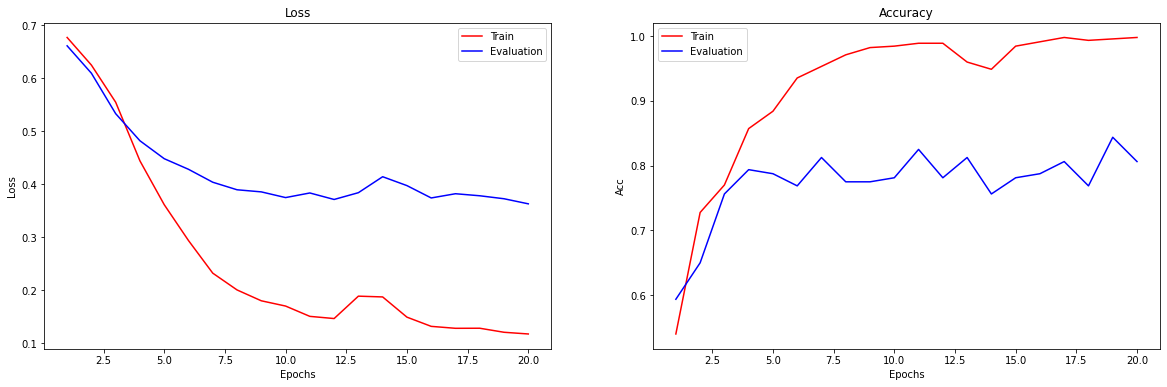

In [117]:
# plot training curves
epochs = range(1, len(hist['train_loss']) + 1)

fig, ax = plt.subplots(1,2, figsize=(20,6))
ax[0].plot(epochs, hist['train_loss'], 'r-', label='Train')
ax[0].plot(epochs, hist['val_loss'], 'b-', label='Evaluation')
ax[0].set_title('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()


ax[1].plot(epochs, hist['train_acc'], 'r-', label='Train')
ax[1].plot(epochs, hist['val_acc'], 'b-', label='Evaluation')
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Acc')
ax[1].legend()

plt.show()